# Preprocessing, GridSearch and Training F-DenseNet-6 on Private Data
# Part 2/2

In [1]:
import numpy as np
from numpy import array
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import math

import matplotlib.pylab as plt
from matplotlib.pyplot import cm
import seaborn as sns
import itertools
import collections
from collections import OrderedDict, Counter

import scipy.stats as stats
from scipy.stats import normaltest, kstest, ttest_ind, ttest_rel, mannwhitneyu, wilcoxon, levene, bartlett
from scipy.stats import chi2_contingency, fisher_exact, mode, pearsonr, f_oneway, kruskal, spearmanr

from rfpimp import *

from datetime import datetime
import re
from seaborn import heatmap
import random
import statsmodels.distributions.empirical_distribution as edf
from scipy.interpolate import interp1d
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from functools import reduce
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

from sklearn import metrics, preprocessing
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, log_loss, recall_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer

from sklearn.utils import check_consistent_length, column_or_1d, assert_all_finite
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.multiclass import type_of_target
from sklearn.linear_model import LogisticRegression
import re
import gc

import os

#from sklearn.externals import joblib
import joblib

from importlib import reload
import Filter_and_Grid_Search
Filter_and_Grid_Search = reload(Filter_and_Grid_Search)
from Filter_and_Grid_Search import stratified_split
from Filter_and_Grid_Search import attributes_list, attributes_list_new
from Filter_and_Grid_Search import get_s_stat, get_PSI_stat, get_stats_by_month, get_stats, stable_unstable
from Filter_and_Grid_Search import stable_unstable_by_month_divide, union_datas, individual_hists_all 
from Filter_and_Grid_Search import paired_time_hists_by_month, statistics_with_target
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import statistics_with_target, attributes_list, attributes_list_new, make_standard
from Filter_and_Grid_Search import data_preprocessing_train, data_preprocessing_test
from Filter_and_Grid_Search import receive_correlations, find_doubles_corr
from Filter_and_Grid_Search import stratified_split, two_forests, turn_variables_with_values
from Filter_and_Grid_Search import find_meta_params, calculate_vif#, find_meta_params_mem
from Filter_and_Grid_Search import plot_meta_2d, data_preprocessing, find_ouliers_iqr
from Filter_and_Grid_Search import train_model_receive_stats, simple_b_score_risk
from Filter_and_Grid_Search import max_prof_corve, by_month_gini, check_attribute_list_cases

from Filter_and_Grid_Search import to_zip, br_correction, br_stat

from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import pathlib
import psutil

C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


## Loading preprocessed data

In [3]:
PATH = 'D:/Share/safanasev/Python-notebook/AF_ML_v2_2014/'

In [4]:
target = 'BAD_FLAG'
index_month = 'MONTH_YEAR'
list_of_vars_for_strat = ['MONTH_YEAR']
sort_by_var = 'APPPOSID'

necessary_fields = [target, index_month, sort_by_var]

COL_DEL = ['Unnamed: 0', 'PERIOD_7', 'LOSS_90P'] 
COL_DEL = [x.upper() for x in COL_DEL]
COL_TRG = target

In [5]:
#загружаем данные для 163 переменных

train_for = pd.read_csv(PATH + 'train_163_prep.csv')
valid_for = pd.read_csv(PATH + 'valid_163_prep.csv')
test_for = pd.read_csv(PATH + 'test_163_prep.csv')

In [6]:
y_train = train_for[target]
#y_test = valid_for[target]
#y_val = test_for[target]

y_test = test_for[target]
y_val = valid_for[target]

train_for.drop('Unnamed: 0', axis = 1, inplace = True)
valid_for.drop('Unnamed: 0', axis = 1, inplace = True)
test_for.drop('Unnamed: 0', axis = 1, inplace = True)


col = train_for.columns.to_list()
col.remove(target)


X_1_2 = train_for[col]
X_2_2 = valid_for[col]
X_3_2 = test_for[col]

In [7]:
#проверка корректности
X_1_2.shape, train_for.shape, len(y_train)

((1507599, 163), (1507599, 164), 1507599)

In [8]:
#проверка корректности, должно быть везде True
print(X_1_2.shape[0] == train_for.shape[0])
print(X_1_2.shape[1] == train_for.shape[1] - 1)
print(len(y_train) == train_for.shape[0])

True
True
True


In [9]:
#проверка корректности, должно быть везде True
print(X_2_2.shape[0] == valid_for.shape[0])
print(X_2_2.shape[1] == valid_for.shape[1] - 1)
print(len(y_val) == valid_for.shape[0])

True
True
True


In [10]:
x_col = X_2_2.columns
y_col = 'BAD_FLAG'

In [11]:
task = 'binary'
missing_strings = 'MISSING'
p_value = 0.05
target_dict = {'good': 0, 'bad': 1}

In [12]:
from keras.utils import np_utils

In [13]:
Y_test_2 = np_utils.to_categorical(y_val, 2) # преобразовываем в 2 класса 

In [14]:
len(x_col)

163

In [15]:
X_2_2.shape, Y_test_2.shape

((185400, 163), (185400, 2))

## Tensorflow

In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Activation, Dense, Flatten, Dropout)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D)
from tensorflow.keras.layers import add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from keras.utils import np_utils

In [17]:
from tensorflow.keras.layers import ReLU, Concatenate, GlobalAveragePooling1D

In [18]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 29

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.compat.v1.set_random_seed(seed_value)


# 5. Configure a new global `tensorflow` session
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [19]:
#если alpha не задано, то не делаем br_correction

class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,  dataset, x_col, y_col,  batch_size=256, num_classes=2, alpha = 0.1, random_state = 42, 
                 shuffle=True, class_w = None):
        self.batch_size = batch_size
        self.dataset = dataset
        self.x_col = x_col
        self.y_col = y_col
        self.indices = self.dataset.index.tolist()
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.alpha = alpha
        self.random_state = random_state
        self.class_w = class_w
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        index = self.index[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in index]
        
        data_tmp = self.dataset.loc[batch]
        data_tmp_b = data_tmp[data_tmp[self.y_col] == 1]
        data_tmp_b_all = self.dataset[self.dataset[self.y_col] == 1]
        X_tmp = data_tmp.head(0)
        
        
        #print(data_tmp_b.shape[0], data_tmp.shape[0], data_tmp_b_all.shape[0])
        if (self.alpha is None) and (self.class_w is None):
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col] 
            
        elif (self.alpha is None) and self.class_w > 0:
            k = (self.class_w*self.batch_size)/(1-self.class_w)
            k = k - data_tmp_b.shape[0]
            if int(k) < 1:
                k = k+1
            ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
            X_tmp = data_tmp_b_all.iloc[ix2]
            data_tmp = data_tmp.append(X_tmp, ignore_index=True)
            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]
            #print(data_tmp_b.shape[0], data_tmp.shape[0],  data_tmp_b.shape[0]/(data_tmp.shape[0] - X_tmp.shape[0]), np.mean(y)) 
            
            
            
        else:
            if data_tmp_b.shape[0] > 0:
                k=(self.alpha*self.batch_size/data_tmp_b.shape[0] -1 )/(1-self.alpha)
                for i in range(0,int(k)):
                    X_tmp = X_tmp.append(data_tmp_b, ignore_index=True)
            else:
                k = (self.alpha*self.batch_size)/(1-self.alpha)
                ix2 = np.random.RandomState(self.random_state + int(k)).choice(data_tmp_b_all.shape[0], int(k))
                X_tmp = data_tmp_b_all.iloc[ix2]
                data_tmp_b = X_tmp

    #         print('Добавим дробное число строк')    
            k_fraction = k - int(k)
            n_samples = int(round(data_tmp_b.shape[0]*k_fraction))
    #         print(k_fraction, n_samples)

            ix = np.random.RandomState(self.random_state).choice(data_tmp_b.shape[0], n_samples)
            data_add_fraction = data_tmp_b.iloc[ix]
            X_tmp.append(data_add_fraction, ignore_index=True)

            data_tmp = data_tmp.append(X_tmp, ignore_index=True)


            X = data_tmp[self.x_col] #.reshape(-1)
            y = data_tmp[self.y_col]   
        #print(sum(self.dataset.loc[batch][self.y_col])/len(index), np.mean(y))
        
        if self.num_classes > 1:
            y = np_utils.to_categorical( y, self.num_classes)
            
        ####for tf 2.3.0, [np.array(X)], np.array(y)

        #return [np.array(X).reshape(X.shape[0], X.shape[1], 1)], np.array(y)
        return [np.array(X)], np.array(y)

    def on_epoch_end(self):
        self.index = np.arange(len(self.indices))
        if self.shuffle == True:
            np.random.shuffle(self.index)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping, Callback

# объявляем класс метрик

class E_time(Callback):
    def on_train_begin(self, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('train_begin', '| time: ' , tm)
        
    def on_epoch_end(self, epoch, logs={}):
        tm = datetime.strftime(datetime.now(), "%d.%m.%Y %H:%M:%S")
        print ('epoch_end', '| time: ' , tm)
    
        return

_time = E_time()

In [21]:
class Metrics(tf.keras.callbacks.Callback):
    def __init__(self, valid_data):
        super(Metrics, self).__init__()
        self.validation_data = valid_data

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_predict = self.model.predict(self.validation_data[0])[:, 1]
        val_targ = self.validation_data[1]
        
        if len(val_targ.shape) == 2: #and val_targ.shape[1] != 1:
            val_targ = val_targ[:,1]

        _val_aps = metrics.average_precision_score(val_targ, val_predict)
        #_val_recall = metrics.recall_score(val_targ, val_predict)
        _val_a = metrics.roc_auc_score(val_targ, val_predict)

        logs['val_aps'] = _val_aps
        logs['val_a'] = _val_a
        print(" — val_aps:  %f — val_a: %f" % (_val_aps, _val_a))
        return

In [22]:
def max_pool(min_pool, n_pool, padding_pool,  str_pool, y, str_min = 1):
    #for 3D-tensor
    if y.shape[1] < (min_pool):
        
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_min)(y)
    else:
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_pool)(y)

## F-DenseNet-6 (with poolings after each convolution)

In [23]:
def fraud_dense_model_6_pool(l2_conv = None, reg = 1E-5 , reg_dense = 1E-5,
                 _bias = True,  n_features = 163, n_pool = 2, n_kernel = 5, n_filters = 5, n_strides = 1,
                 classes = 2, hidden = 64 , drop_out = 0.25, drop_out_conv = 0.001, drop_out_rate = 4 ,
                 padding_pool = 'valid' ,
                gl_pool_max = False):
    
    if reg == None:
        l2_batch_gamma = None 
        l2_batch_betta = None
    else:
        l2_batch_gamma = l2(reg)
        l2_batch_betta =l2(reg)
    
    if reg_dense == None:
        kernel_regularizer = None
    else:
        kernel_regularizer = l2(reg)   
    
    
    x = Input(shape=(  n_features, 1))
    n = 0
    y = Conv1D(filters=n_filters, kernel_size=n_kernel, strides=n_strides, padding='same', 
           use_bias=_bias, kernel_regularizer=l2_conv)(x) 

    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
#y = Dropout(rate=drop_rate)(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut1_2 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)## поправить


    # второй conv-block
    y = Conv1D(filters=n_filters*2, kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##


    y= Concatenate(axis=-1)([shortcut1_2, y])
    n = n+1

    # третий conv-block
    y = Conv1D(filters=n_filters*(3 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    n = n+1
    
    # четвертый conv-block
    y = Conv1D(filters=n_filters*(4 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    shortcut4_6 = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y)##

    # пятый conv-block
    y = Conv1D(filters=n_filters*(5 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)

    y = MaxPooling1D(pool_size = n_pool, padding=padding_pool)(y) ##
    y= Concatenate(axis=-1)([shortcut4_6,  y])

    # шестой conv-block
    y = Conv1D(filters=n_filters*(6 + 1), kernel_size=n_kernel, strides=n_strides, padding='same',
              use_bias=_bias, kernel_regularizer=l2_conv)(y) 
    y = BatchNormalization(gamma_regularizer=l2_batch_gamma ,beta_regularizer=l2_batch_betta)(y)
    y = ReLU()(y)
    if gl_pool_max:
        z = GlobalMaxPooling1D()(y)
        
    else:
        z = GlobalAveragePooling1D()(y)
    #z = Flatten()(y) #сглаживание, пример использования - https://stackoverflow.com/questions/43237124/what-is-the-role-of-flatten-in-keras
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    z = Dense(hidden, activation='relu', kernel_regularizer = kernel_regularizer)(z)
    z = Dropout(drop_out)(z)
    predictions = Dense(classes, activation='softmax')(z)

    #model = Sequential()
    model_15 = Model(inputs=x, outputs=predictions)
    
    return model_15

In [24]:
def max_pool(min_pool, n_pool, padding_pool, str_pool, y ):
    if y.shape[1] < (min_pool):
        
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=1)(y)
    else:
        return MaxPooling1D(pool_size = n_pool, padding=padding_pool, strides=str_pool)(y)

In [25]:
test_model_1 = fraud_dense_model_6_pool()
test_model_1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 163, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 163, 5)       30          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 163, 5)       20          conv1d[0][0]                     
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 163, 5)       0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [26]:
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

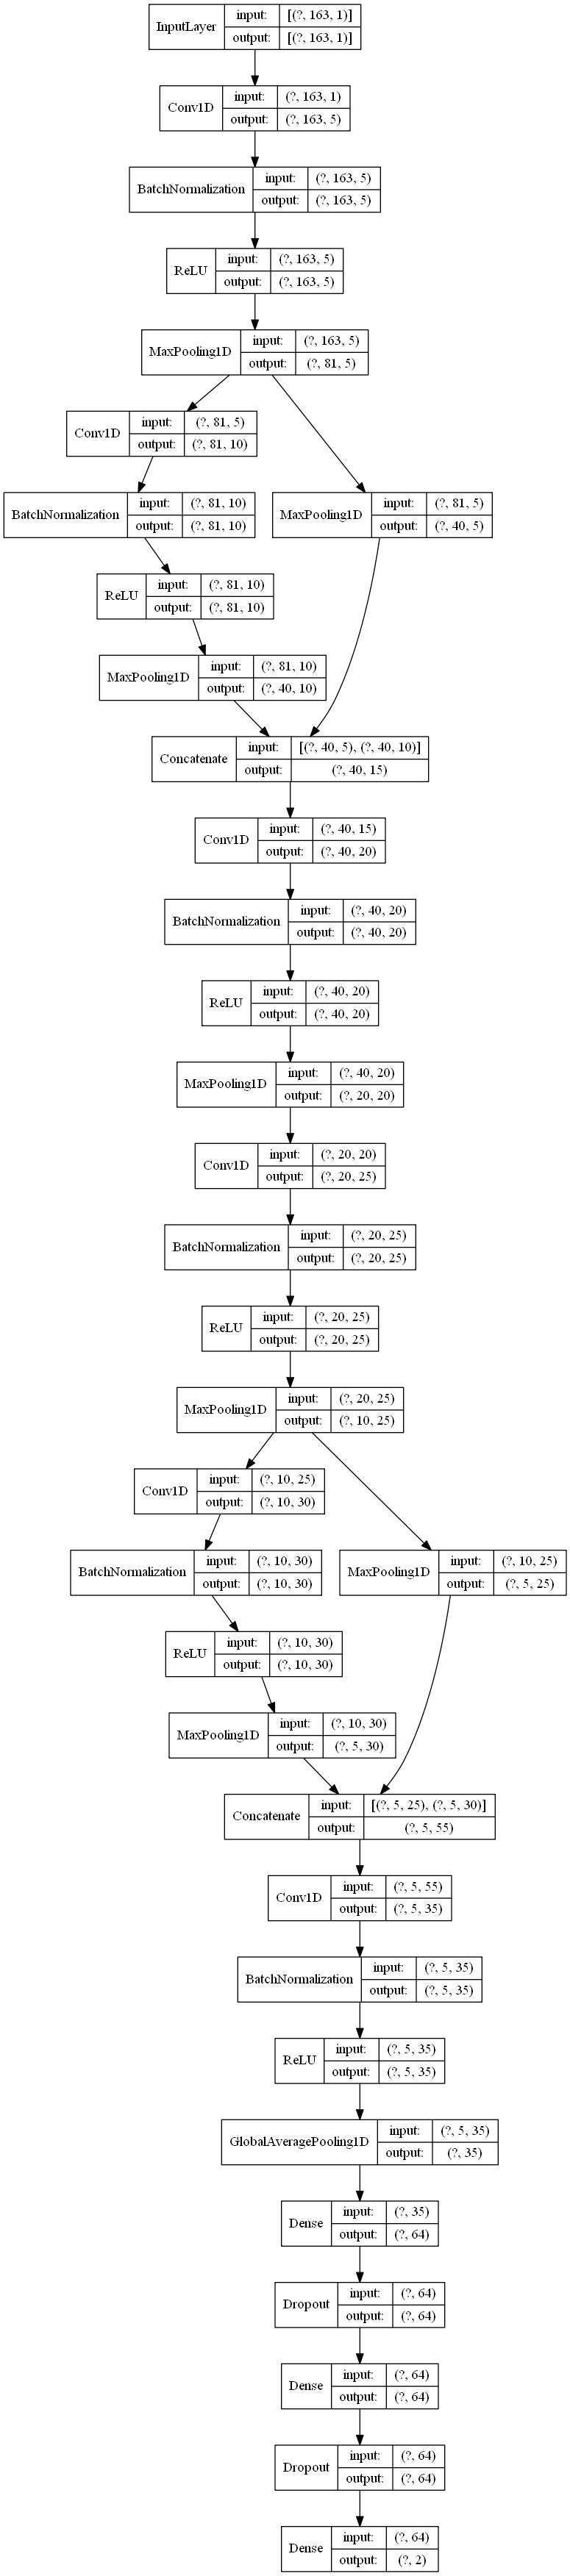

In [27]:
tf.keras.utils.plot_model(test_model_1, to_file='test_model_1_fdense_PrivateData.png', show_shapes=True, show_layer_names=False, rankdir='TB')

In [28]:
test = pd.DataFrame.from_dict(test_model_1.get_config()['layers'])
c = dict()
for i in test[test['class_name'] =='Conv1D'].index:
    c[i] = {'kernel':(test[test['class_name'] =='Conv1D']['config'][i]['kernel_size']) ,
    'filter' : (test[test['class_name'] =='Conv1D']['config'][i]['filters'])}
c

{1: {'kernel': (5,), 'filter': 5},
 5: {'kernel': (5,), 'filter': 10},
 11: {'kernel': (5,), 'filter': 20},
 15: {'kernel': (5,), 'filter': 25},
 19: {'kernel': (5,), 'filter': 30},
 25: {'kernel': (5,), 'filter': 35}}

## The 2d part of the hyperparameter gridsearch

In [29]:
gl_p = [False] #0
l2_batch = [ 0.0002] #1
n_ker = [7] #2
n_fil = [15] #3
d_hidden = [100] #4
drop_out = [0.25] #5
reg_dense = [0.0002] #6
min_pool = [20] #7
# n_lay = [3, 6] #8  # это для CNN-сетки

In [30]:
param = itertools.product(gl_p, l2_batch, n_ker, n_fil, d_hidden, drop_out, reg_dense, min_pool)

In [31]:
inp_shape = X_2_2.shape[1]
inp_shape

163

In [32]:
training_generator = DataGenerator(train_for, x_col, y_col, batch_size=512, alpha = None, class_w = 0.1)

## F-DenseNet-6

In [33]:
VERBOSE = 2
BATCH_SIZE = 512
NB_EPOCH = 150
class_weighting = {0: 0.1, 1: 1}

result_all_8 = pd.DataFrame()
result_all_8['name_model'] = None
result_all_8['params'] = None
result_all_8['val_GINI'] = None
result_all_8['val_APS'] = None
result_all_8['test_GINI'] = None
result_all_8['test_APS'] = None
j = 0

for p in param:
    print(inp_shape, X_2_2.shape, p)

    
    ###############################
    #Вставить нужную функцию!!!!!!!!
    model_grid = fraud_dense_model_6_pool(l2_conv = None, reg = p[1] , reg_dense = p[6],
                                          n_features = inp_shape, n_pool = 2, n_kernel = p[2], n_filters = p[3],
                                          n_strides = 1, classes = 2, hidden = p[4], drop_out = 0.25,
                                          drop_out_conv = 0.001, drop_out_rate = 4, padding_pool = 'valid',
                                          gl_pool_max = False)

    model_grid.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.Adam(learning_rate=0.003),
                       metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    history_XX = model_grid.fit_generator(generator=training_generator,  # training_aug,
                                          # Y_test_2 = np_utils.to_categorical( y_val, 2)
                                          validation_data=(X_2_2, Y_test_2),
                                          epochs=NB_EPOCH, verbose=VERBOSE, class_weight=class_weighting,
                                          callbacks=[_time, EarlyStopping(monitor='val_loss', patience=20),
                                                     Metrics(valid_data=(X_2_2, Y_test_2))])

    res_model_ = pd.DataFrame(
        history_XX.history, columns=history_XX.history.keys())
    dd = str(200000 + datetime.now().month*100 +
             datetime.now().day) + '_' + str(datetime.now().hour)
    name_m = 'model_fDenseNet6_PrivateData_' + str(p[1]) + '_' + str(
        p[2]) + '_' + str(p[3]) + '_' + str(p[4]) + '_' + str(p[6]) + '_' + str(dd)

    model_grid.save(name_m + '.h5')
    res_model_.to_csv(name_m + '.csv')

    predict_class_val = model_grid.predict(X_2_2)
    APS = metrics.average_precision_score(y_val, predict_class_val[:,1])
    GINI = 2*(metrics.roc_auc_score(y_val , predict_class_val[:,1])) - 1

    predict_class_test = model_grid.predict(X_3_2)
    APS_t = metrics.average_precision_score(y_test, predict_class_test[:,1])
    GINI_t = 2*(metrics.roc_auc_score(y_test, predict_class_test[:,1])) - 1

    result_all_8.at[j, 'name_model'] = name_m
    result_all_8.at[j, 'params'] = str(p)
    result_all_8.at[j, 'val_GINI'] = GINI
    result_all_8.at[j, 'val_APS'] = APS
    result_all_8.at[j, 'test_GINI'] = GINI_t
    result_all_8.at[j, 'test_APS'] = APS_t

    result_all_8.to_csv('model_fDenseNet6_PrivateData_all_part2.csv')
    j += 1
    print('==============================================')
    print(name_m, 'valid_for_train: ', GINI, APS, '| test: ', GINI_t, APS_t)
    print('==============================================')
    print('')
    


163 (185400, 163) (False, 0.0002, 7, 15, 100, 0.25, 0.0002, 20)
Instructions for updating:
Please use Model.fit, which supports generators.
train_begin | time:  10.05.2021 00:14:42
Epoch 1/150
epoch_end | time:  10.05.2021 00:53:41
 — val_aps:  0.088988 — val_a: 0.936098
2945/2945 - 2372s - loss: 0.0224 - accuracy: 0.9843 - auc: 0.9973 - precision: 0.9843 - recall: 0.9843 - val_loss: 0.0392 - val_accuracy: 0.9931 - val_auc: 0.9994 - val_precision: 0.9931 - val_recall: 0.9931
Epoch 2/150
epoch_end | time:  10.05.2021 01:33:19
 — val_aps:  0.055140 — val_a: 0.921223
2945/2945 - 2374s - loss: 0.0085 - accuracy: 0.9923 - auc: 0.9989 - precision: 0.9923 - recall: 0.9923 - val_loss: 0.4065 - val_accuracy: 0.8855 - val_auc: 0.9307 - val_precision: 0.8855 - val_recall: 0.8855
Epoch 3/150
epoch_end | time:  10.05.2021 02:12:44
 — val_aps:  0.080374 — val_a: 0.917534
2945/2945 - 2367s - loss: 0.0076 - accuracy: 0.9931 - auc: 0.9992 - precision: 0.9931 - recall: 0.9931 - val_loss: 0.0204 - val_ac

 — val_aps:  0.067402 — val_a: 0.923398
2945/2945 - 2346s - loss: 0.0037 - accuracy: 0.9957 - auc: 0.9997 - precision: 0.9957 - recall: 0.9957 - val_loss: 0.0476 - val_accuracy: 0.9842 - val_auc: 0.9979 - val_precision: 0.9842 - val_recall: 0.9842
Epoch 28/150
epoch_end | time:  10.05.2021 18:30:13
 — val_aps:  0.040710 — val_a: 0.897072
2945/2945 - 2141s - loss: 0.0035 - accuracy: 0.9960 - auc: 0.9998 - precision: 0.9960 - recall: 0.9960 - val_loss: 0.1170 - val_accuracy: 0.9613 - val_auc: 0.9911 - val_precision: 0.9613 - val_recall: 0.9613
Epoch 29/150
epoch_end | time:  10.05.2021 19:07:27
 — val_aps:  0.046887 — val_a: 0.913141
2945/2945 - 2232s - loss: 0.0035 - accuracy: 0.9960 - auc: 0.9997 - precision: 0.9960 - recall: 0.9960 - val_loss: 0.0466 - val_accuracy: 0.9856 - val_auc: 0.9976 - val_precision: 0.9856 - val_recall: 0.9856
Epoch 30/150
epoch_end | time:  10.05.2021 19:42:03
 — val_aps:  0.060064 — val_a: 0.911159
2945/2945 - 2075s - loss: 0.0034 - accuracy: 0.9961 - auc: 0